In [1]:
import warnings
warnings.filterwarnings('ignore')

### Установим красивые дефолтные настройки
### Может быть лень постоянно прописывать
### У графиков параметры цвета, размера, шрифта
### Можно положить их в словарь дефолтных настроек

import matplotlib as mlp

mlp.rcParams['lines.linewidth'] = 5
mlp.rcParams['xtick.major.size'] = 20
mlp.rcParams['xtick.major.width'] = 5
mlp.rcParams['xtick.labelsize'] = 20
mlp.rcParams['xtick.color'] = '#FF5533'

mlp.rcParams['ytick.major.size'] = 20
mlp.rcParams['ytick.major.width'] = 5
mlp.rcParams['ytick.labelsize'] = 20
mlp.rcParams['ytick.color'] = '#FF5533'

mlp.rcParams['axes.labelsize'] = 20
mlp.rcParams['axes.titlesize'] = 20
mlp.rcParams['axes.titlecolor'] = '#00B050'
mlp.rcParams['axes.labelcolor'] = '#00B050'

### Предсказание отклика банковских клиентов на основе данных маркетинговой кампании португальских банков

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.display.max_columns = 500

df = pd.read_csv("banking.csv")
df.shape

(41188, 21)

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,210,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,138,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,339,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,185,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,137,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


<dl>
<dt> Описание колонок:
<dd>age - возраст клиента </dd>
<dd>job - тип работы </dd>
<dd>marital - статус замужества</dd>
<dd>education - степень образования </dd>
<dd>default - дефолтил ли клиент? </dd>
<dd>housing - есть ли жилищный кредит? </dd>
<dd>loan - есть ли потребительский кредит? </dd>
<dd>contact - тип коммуникации </dd>
<dd>month - месяц последнего контакта </dd>
<dd>day_of_week - день недели последнего контакта </dd>
<dd>duration - длительность последнего звонка - стоит убрать при обучении модели </dd>
<dd>campaign - количество звонков в течение маркетинговой кампании </dd>
<dd>pdays - как давно не было коммуникации с клиентом, относительно предыдущей маркетинговой кампании </dd>
<dd>previous - количество звоноков до текущей маркетинговой компании </dd>
<dd>poutcome - результат предыдущей маркентинговой кампании относительно выбранного клиента </dd>
<dd>emp.var.rate - коэффициент вариации безработицы (quarterly) </dd>
<dd>cons.price.idx - индекс потребительских цен (monthly) </dd>
<dd>cons.conf.idx: - индекс потребительской уверенности (monthly) </dd>
<dd>euribor3m - межбанковская европейская ставка предложения по трехмесячному займу (daily) </dd>
<dd>nr.employed - количество занятых </dd>
<dd>y - таргетная переменная: взял ли клиент депозит </dd>
</dl>

**Наша целевая переменная - взял ли клиент депозит.**

In [4]:
### Уберем колонку duration

df = df.drop('duration', axis=1)

In [5]:
### Посмотрим на некатегориальные колонки

numeric_columns = df.loc[:,df.dtypes!=np.object].columns
df.loc[:,df.dtypes!=np.object].head(2)

,age,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,1,999,0,1.4,93.444,-36.1,4.963,5228.1,0
1,53,1,999,0,-0.1,93.200,-42.0,4.021,5195.8,0


In [6]:
### Посмотрим на категориальные колонки

categorical_columns = df.loc[:,df.dtypes==np.object].columns
df.loc[:,df.dtypes==np.object].head(2)

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,nonexistent
1,technician,married,unknown,no,no,no,cellular,nov,fri,nonexistent


### Развернем EDA на категориальных колонках. А так же методы фильтрации на вещественных. Вдруг от каких-то получится избавиться заранее, чтобы не плодить огромный датасет!

In [7]:
df.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

In [8]:
### Есть ли пропуски?

df.describe()

,age,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.112654
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.316173
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


In [9]:
### Изучим корелляции вещественных признаков

df[numeric_columns].corr()

,age,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
age,1.000000,0.004594,-0.034369,0.024365,-0.000371,0.000857,0.129372,0.010767,-0.017725,0.030399
campaign,0.004594,1.000000,0.052584,-0.079141,0.150754,0.127836,-0.013733,0.135133,0.144095,-0.066357
pdays,-0.034369,0.052584,1.000000,-0.587514,0.271004,0.078889,-0.091342,0.296899,0.372605,-0.324914
previous,0.024365,-0.079141,-0.587514,1.000000,-0.420489,-0.203130,-0.050936,-0.454494,-0.501333,0.230181
emp_var_rate,-0.000371,0.150754,0.271004,-0.420489,1.000000,0.775334,0.196041,0.972245,0.906970,-0.298334
cons_price_idx,0.000857,0.127836,0.078889,-0.203130,0.775334,1.000000,0.058986,0.688230,0.522034,-0.136211
cons_conf_idx,0.129372,-0.013733,-0.091342,-0.050936,0.196041,0.058986,1.000000,0.277686,0.100513,0.054878
euribor3m,0.010767,0.135133,0.296899,-0.454494,0.972245,0.688230,0.277686,1.000000,0.945154,-0.307771
nr_employed,-0.017725,0.144095,0.372605,-0.501333,0.906970,0.522034,0.100513,0.945154,1.000000,-0.354678
y,0.030399,-0.066357,-0.324914,0.230181,-0.298334,-0.136211,0.054878,-0.307771,-0.354678,1.000000


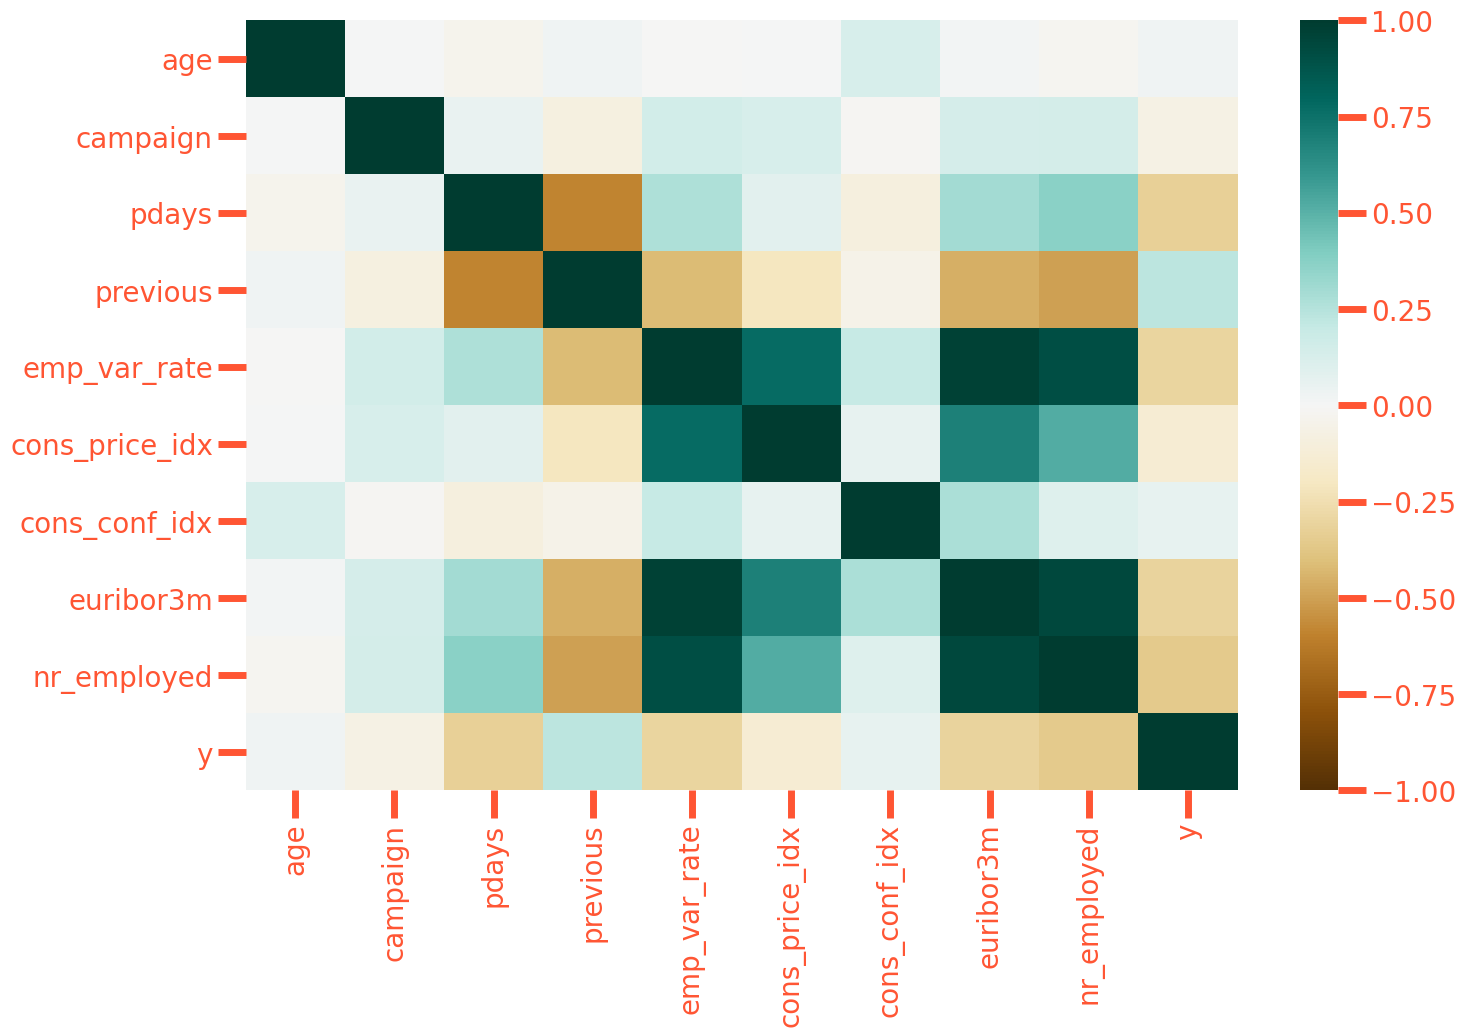

In [10]:
### Изобразим в виде Тепловой карты

import seaborn as sns

fig = plt.figure()

fig.set_size_inches(16, 10)

sns.heatmap(df[numeric_columns].corr(), 
            xticklabels=numeric_columns,
            yticklabels=numeric_columns,
            cmap='BrBG',
            vmin=-1,
            vmax=1)

plt.show()

In [11]:
### Секретные функции для фильтрации признаков

def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df[numeric_columns], 10))

Top Absolute Correlations
emp_var_rate    euribor3m         0.972245
euribor3m       nr_employed       0.945154
emp_var_rate    nr_employed       0.906970
                cons_price_idx    0.775334
cons_price_idx  euribor3m         0.688230
pdays           previous          0.587514
cons_price_idx  nr_employed       0.522034
previous        nr_employed       0.501333
                euribor3m         0.454494
                emp_var_rate      0.420489
dtype: float64


In [12]:
test = df[numeric_columns].drop(['emp_var_rate', 'euribor3m'], axis=1)
get_top_abs_correlations(test, 10)

pdays           previous          0.587514
cons_price_idx  nr_employed       0.522034
previous        nr_employed       0.501333
pdays           nr_employed       0.372605
nr_employed     y                 0.354678
pdays           y                 0.324914
previous        y                 0.230181
                cons_price_idx    0.203130
campaign        nr_employed       0.144095
cons_price_idx  y                 0.136211
dtype: float64

In [13]:
df = df.drop(['emp_var_rate', 'euribor3m'], axis=1)
numeric_columns = numeric_columns.drop(['emp_var_rate', 'euribor3m'])

In [14]:
### Посмотрим на квазиконстантые признаки

from sklearn.feature_selection import VarianceThreshold


cutter = VarianceThreshold(threshold=0.1)
cutter.fit(df[numeric_columns])

cutter.get_feature_names_out()

array(['age', 'campaign', 'pdays', 'previous', 'cons_price_idx',
       'cons_conf_idx', 'nr_employed'], dtype=object)

In [15]:
numeric_columns

Index(['age', 'campaign', 'pdays', 'previous', 'cons_price_idx',
       'cons_conf_idx', 'nr_employed', 'y'],
      dtype='object')

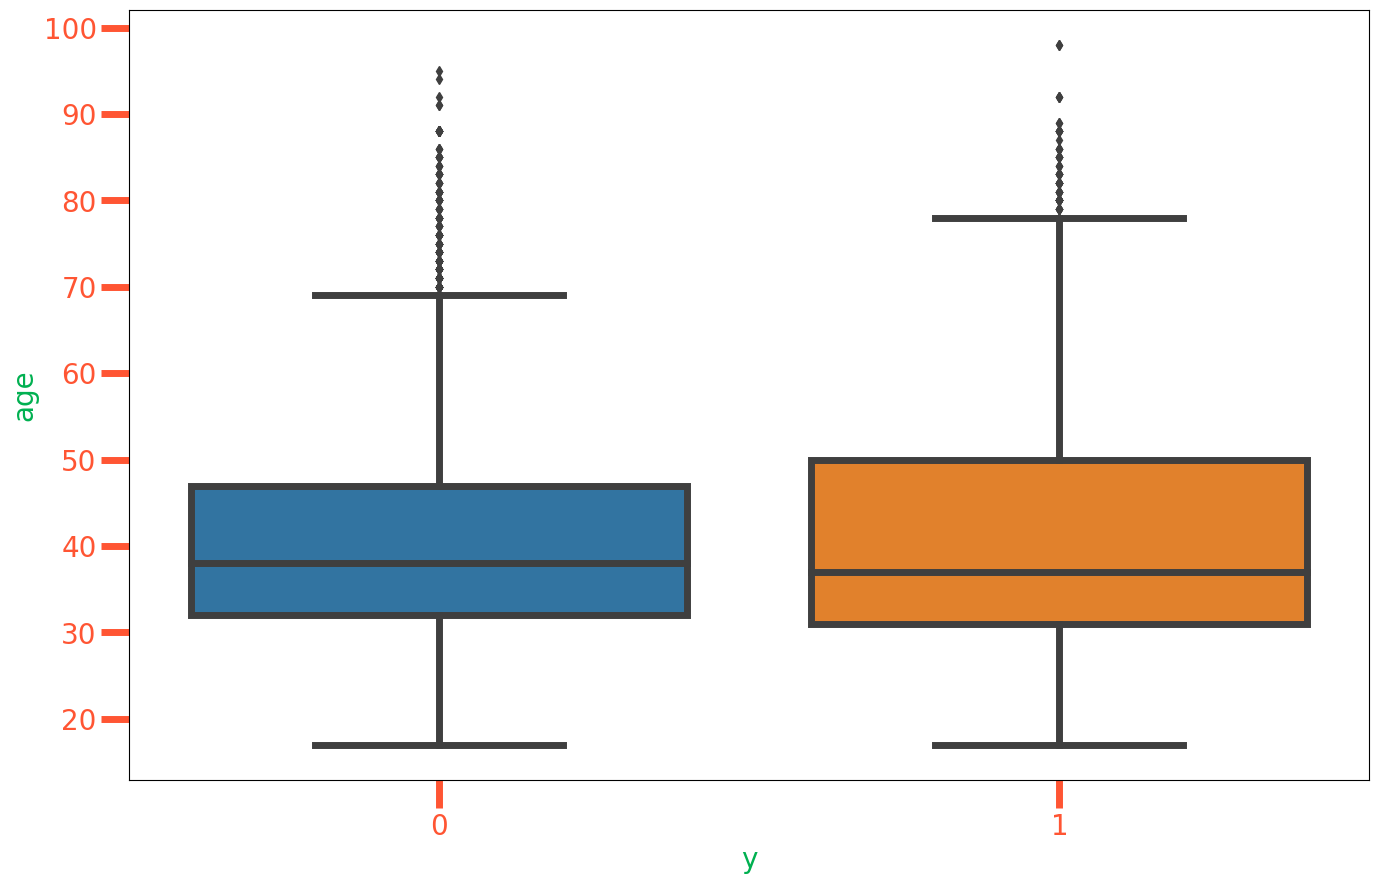

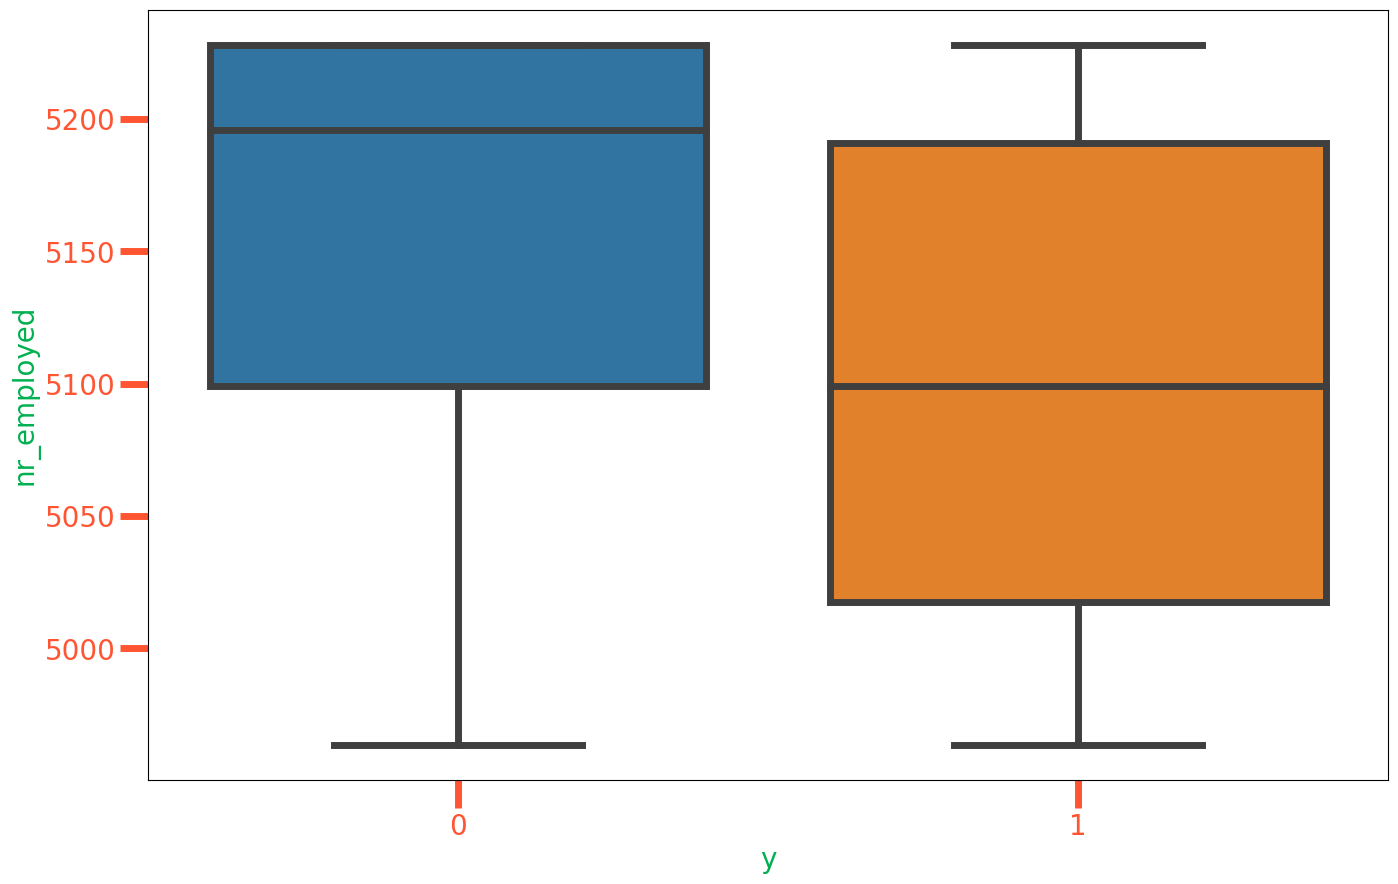

In [16]:
### Еще один способ, как в задаче классификации без построения модели
### оценить важность вещественных признаков- с помощью ящиков с усами!
### Только теперь немного "наоборот", представляя таргет как категорию
### А значения, распределение которых хотим сравнивать, окажутся нашими фичами


num_col = ['age', 'nr_employed']

for col in num_col:
    
    fig = plt.figure()
    fig.set_size_inches(16, 10)
    
    sns.boxplot(y=col, x=df['y'].astype('category'), data=df)
    
    plt.show()






In [17]:
### Посмотрим на распределение категорий среди разных таргетов

df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563


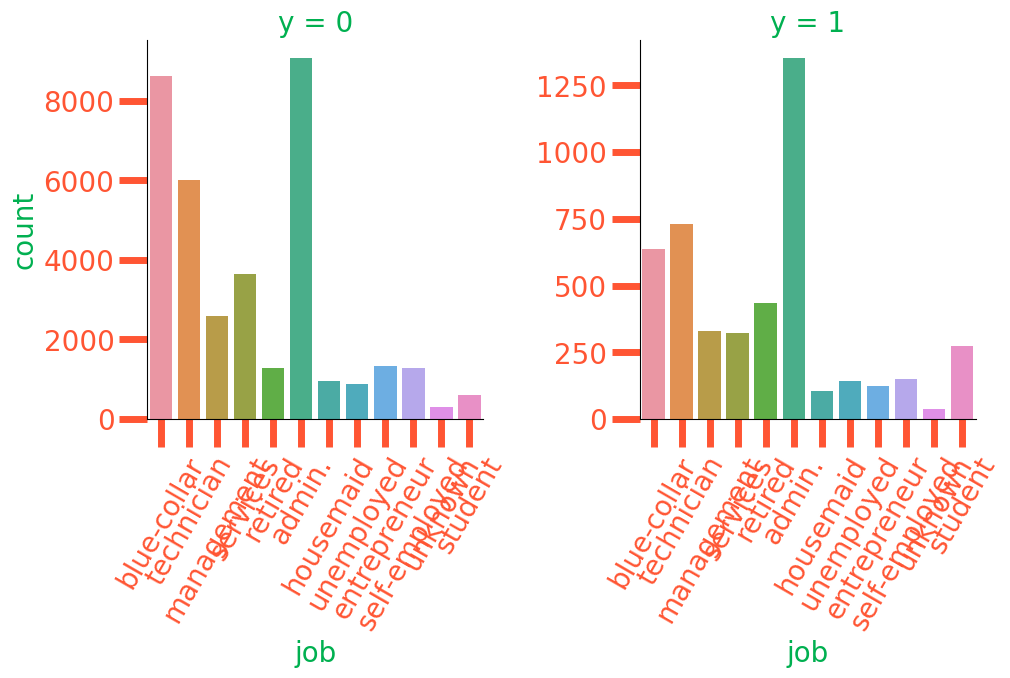

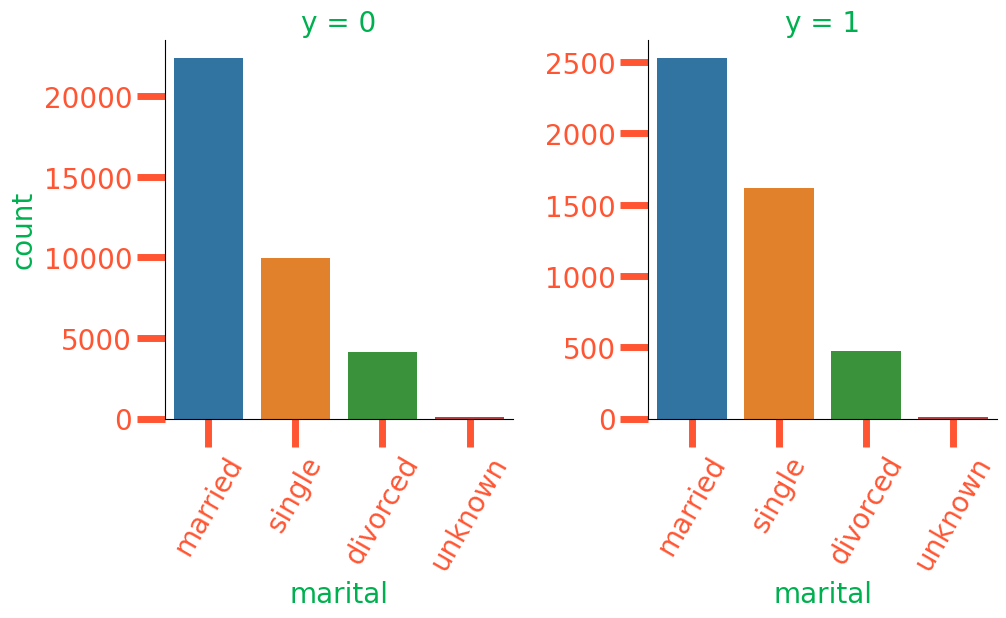

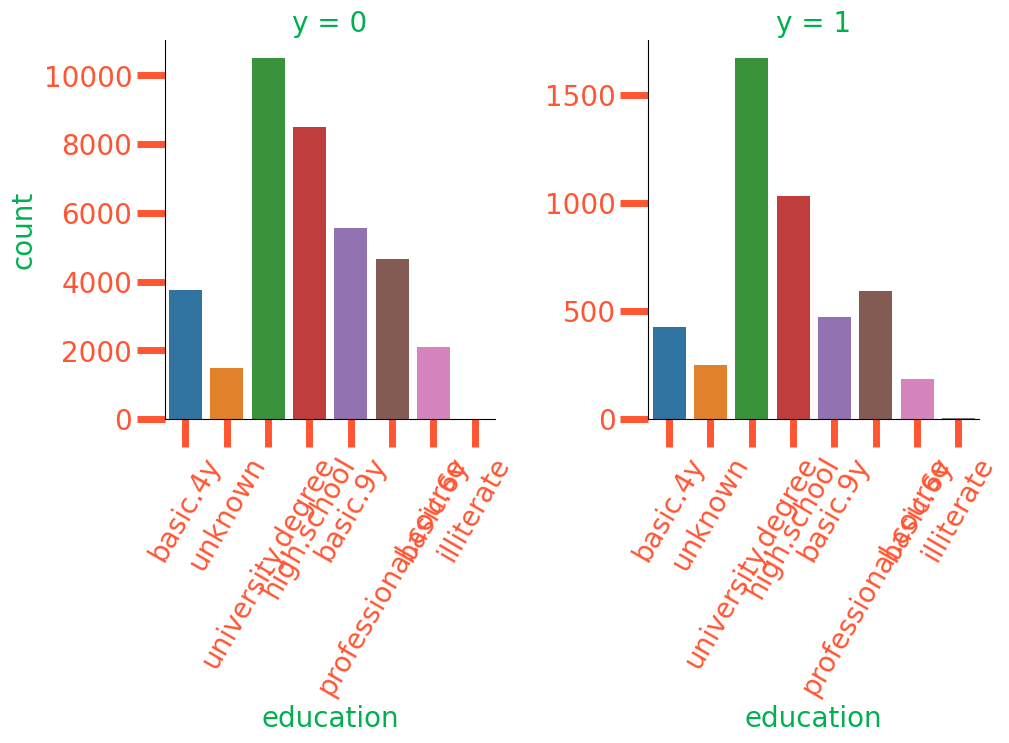

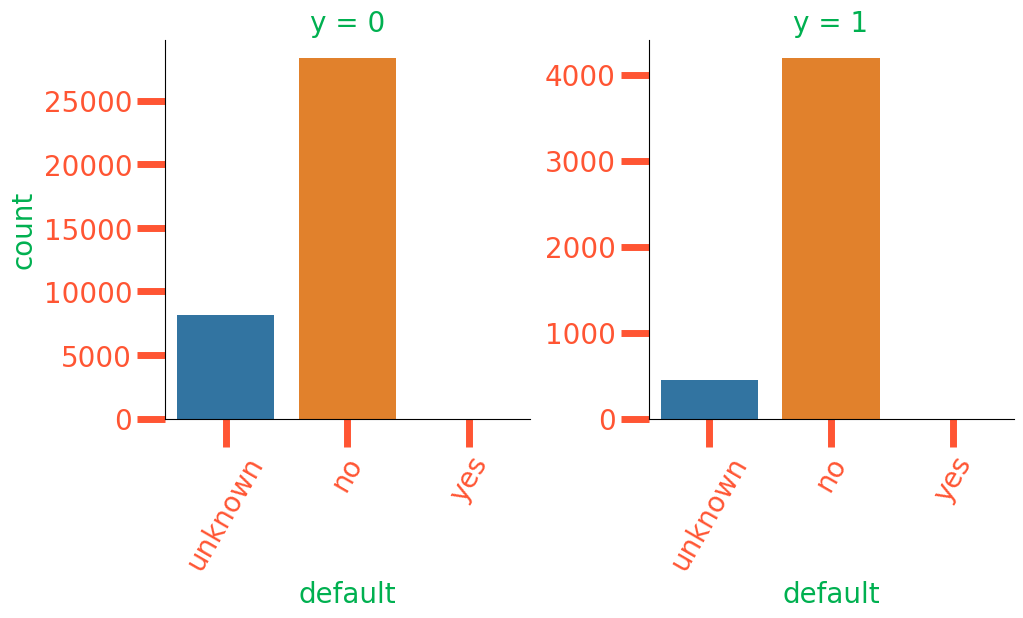

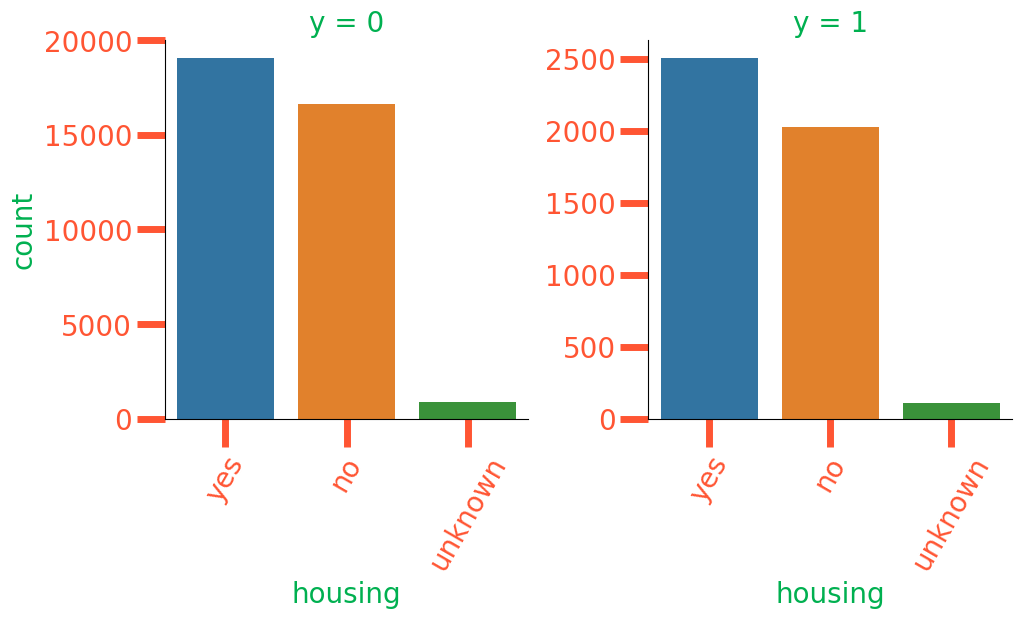

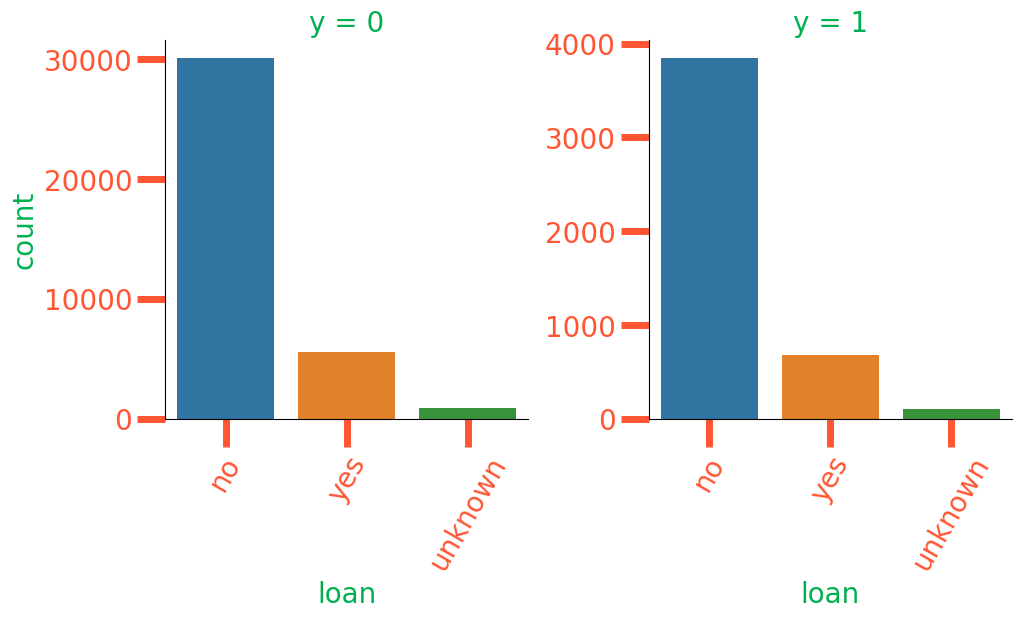

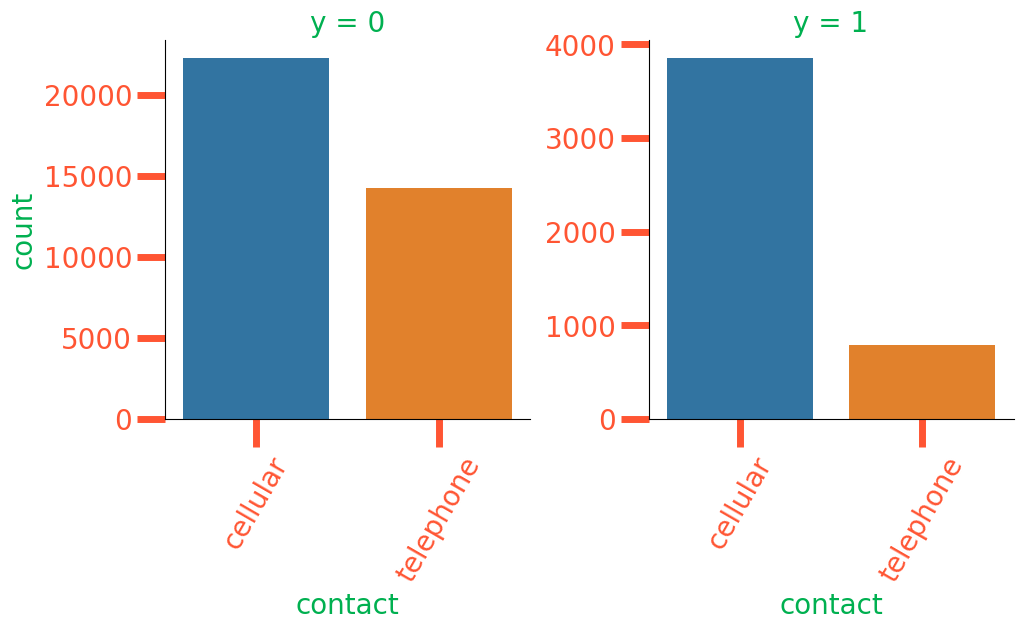

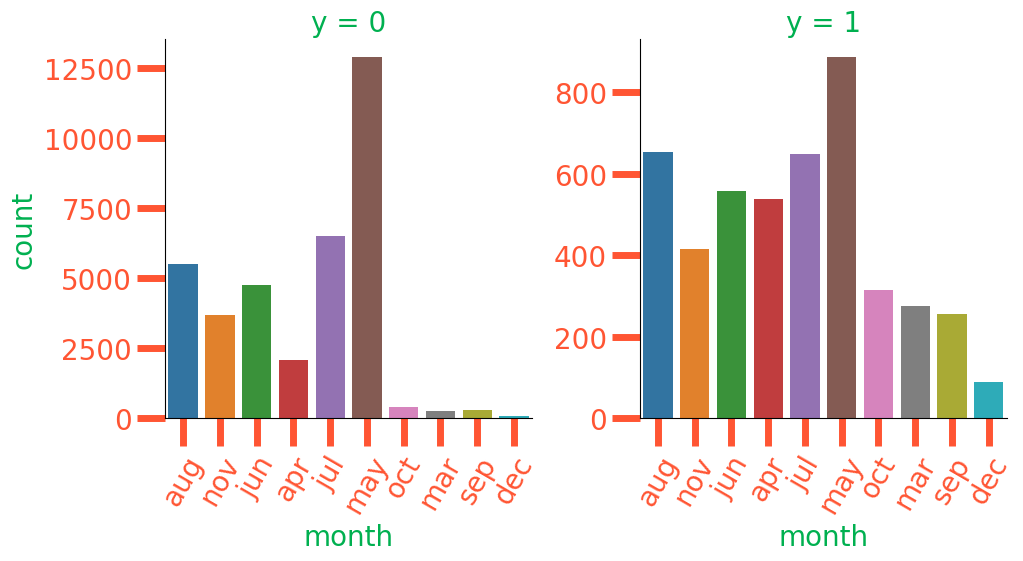

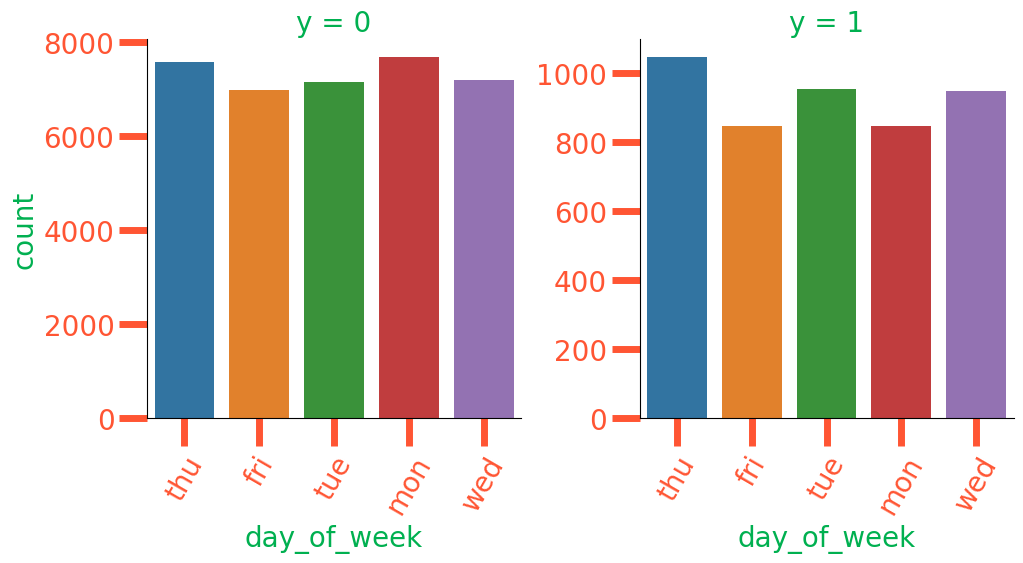

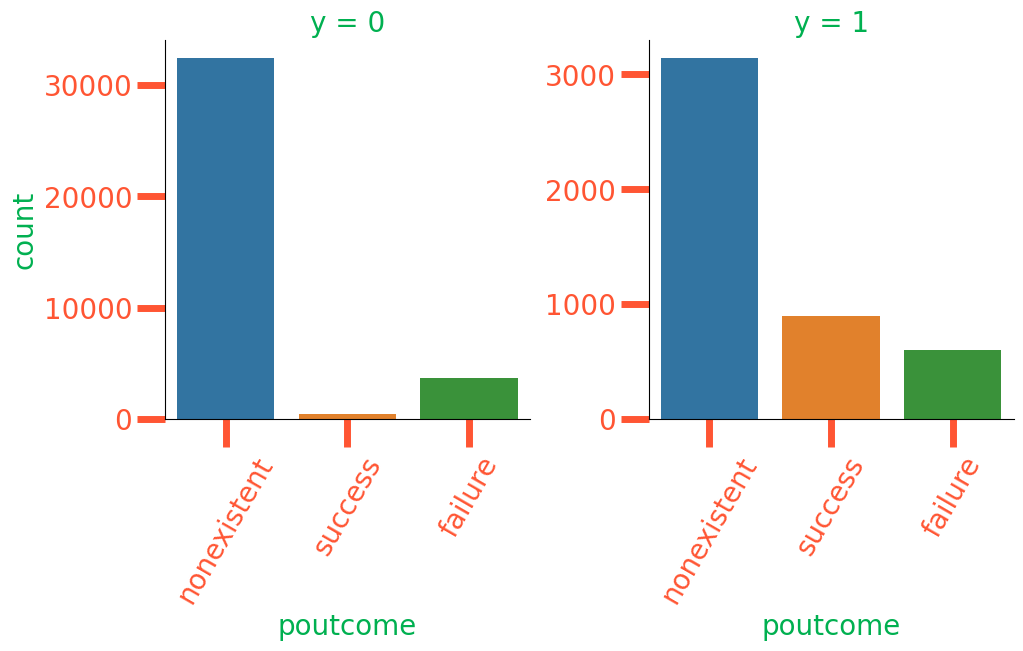

In [18]:
### Гистограммы распределений в разных классах

for col in categorical_columns:
    g = sns.catplot(x=col, kind='count', col='y', data=df, sharey=False)
    g.set_xticklabels(rotation=60)

In [19]:
df = df.drop(['loan', 'housing', 'marital'], axis=1)
categorical_columns = categorical_columns.drop(['loan', 'housing', 'marital'])

In [20]:
df.head().shape

(5, 15)

### Закодируем оставшиеся категориальные фичи!

In [21]:
### Посмотрим, какие можно кодировать с помощью one-hot метода, 
### а для каких лучше посчитать счетчики!

df.describe(include='object')

,job,education,default,contact,month,day_of_week,poutcome
count,41188,41188,41188,41188,41188,41188,41188
unique,12,8,3,2,10,5,3
top,admin.,university.degree,no,cellular,may,thu,nonexistent
freq,10422,12168,32588,26144,13769,8623,35563


In [22]:
for col in categorical_columns:
    
    ### К колонкам с маленькой размерностью применим one-hot
    if df[col].nunique() < 5:
        one_hot = pd.get_dummies(df[col], prefix=col, drop_first=True)
        df = pd.concat((df.drop(col, axis=1), one_hot), axis=1)
        
    ### К остальным - счетчики
    else:
        mean_target = df.groupby(col)['y'].mean()
        df[col] = df[col].map(mean_target)

In [23]:
df.head()

,age,job,education,month,day_of_week,campaign,pdays,previous,cons_price_idx,cons_conf_idx,nr_employed,y,default_unknown,default_yes,contact_telephone,poutcome_nonexistent,poutcome_success
0,44,0.068943,0.102490,0.106021,0.121188,1,999,0,93.444,-36.1,5228.1,0,1,0,0,1,0
1,53,0.108260,0.145003,0.101439,0.108087,1,999,0,93.200,-42.0,5195.8,0,0,0,0,1,0
2,28,0.112175,0.137245,0.105115,0.121188,3,6,2,94.055,-39.8,4991.6,1,0,0,0,0,1
3,39,0.081381,0.108355,0.204787,0.108087,2,999,0,93.075,-47.1,5099.1,0,0,0,0,1,0
4,55,0.252326,0.102490,0.106021,0.108087,1,3,1,92.201,-31.4,5076.2,1,0,0,0,0,1


In [24]:
X = df.drop('y', axis=1)
Y = df['y']

### Обучим Логистическую регрессию!

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    random_state=0, 
                                                    test_size=0.2)

In [26]:
X_train.shape[0], X_test.shape[0]

(32950, 8238)

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

pipe = Pipeline([('scaler', StandardScaler()),
                 ('LR', LogisticRegression(penalty='none'))])  # убираем регуляризацию

pipe.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('LR', LogisticRegression(penalty='none'))])

In [31]:
### Pipeline автоматом для классификации отображает accuracy

pipe.score(X_test, Y_test)

0.9011896091284293

In [32]:
X_test.head(1)

,age,job,education,month,day_of_week,campaign,pdays,previous,cons_price_idx,cons_conf_idx,nr_employed,default_unknown,default_yes,contact_telephone,poutcome_nonexistent,poutcome_success
15500,51,0.068943,0.078246,0.204787,0.099483,4,999,0,93.075,-47.1,5099.1,0,0,0,1,0


In [33]:
### Чтобы предсказать вероятности соответственно классам
### Обратимся к аттрибуту classes_ и к методу predict_proba
### А чтобы понять уверенность модели, воспользуемся методом
### decision_function

print(pipe.classes_)

print(pipe.predict(X_test.head(1)))

print(pipe.predict_proba(X_test.head(1)))

print(pipe.decision_function(X_test.head(2)))

[0 1]
[0]
[[0.88133713 0.11866287]]
[-2.00515374 -2.25746979]


In [34]:
### Константное предсказание на тесте

np.mean(Y_test == 0)

0.8891721291575625

In [35]:
df['y'].value_counts()

0    36548
1     4640
Name: y, dtype: int64